In [1]:
#SECTION 4.1
#import base libararies - everything should be in Anaconda - python 3.x
import string
import json
import re
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import scipy
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import itertools


#Setup stopwords - one time download of these corpus. un comment the line to download
#nltk.download('stopwords')
#nltk.download('punkt')
#download('wordnet')
stop = set(stopwords.words('english'))
np.set_printoptions(suppress=True,precision=10)

#Setup stemmer
ps = PorterStemmer()

#Setup lemmatizer
lmtzr = WordNetLemmatizer()
#lmtzr.lemmatize('feet')

In [2]:
#SECTION 4.2
##Loading Data################################
#removed multi classes in data pysically
def importData (path):
    global df
    xl = pd.ExcelFile(path)
    df = xl.parse("MERGED_NARROW")

importData('data/MERGED_NARROW_Dedupes4.xlsx')

#filter out these support groups
df = df[~df['MA_Support_Group']
    .isin(['Service Desk','#blank#','Communications_DO NOT USE', 'LightLife', 'ZZ Test Support Group',
           'Vendor Lenovo', 'Transportation Management', 'MDSS Conversion', 'SAP Hypercare',
           'Warehouse Management', 'Business Support Services','PMO','Quality & Food Safety','Vendor Compugen',
           'Development', 'IS Compliance', 'Technical Services'
           ])]
df = df[~df['MA_Mis_Assigned_Support_Group']
    .isin(['Yes'])]

#merging title and description and person together. just testing may have to do something else
df['Description'] = df['Title'].map(str) + ' ' + df['Description']

# tokenize, stop words, and then punctuation, stemming, remove numbers respectively
df['tokenized_text'] = df.Description.apply(word_tokenize)
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop])
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if len(item) > 1])
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [lmtzr.lemmatize(item) for item in x])
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [ps.stem(item) for item in x])
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if bool(re.search(r'\d', item))==False])

#df['j_tokenized_text'] = df['tokenized_text'].apply(lambda x: x[:round(len(x)*.5)] )
df['j_tokenized_text'] = df['tokenized_text'].apply(lambda x: [' '.join(x) ])
#

##create test and train set
X_train, X_test, Y_train, Y_test = train_test_split(df[['j_tokenized_text','Team']], df['MA_Support_Group'],
                                                    test_size=0.2)

In [3]:
#SECTION 4.3
##training#####################################
#x's
vectorizer = TfidfVectorizer(ngram_range=(1,1),sublinear_tf=True)
X = vectorizer.fit_transform(X_train['j_tokenized_text'].apply(str))
#y's
le = preprocessing.LabelEncoder()
le.fit(df['MA_Support_Group'].unique())
y = le.transform(Y_train.tolist())

##tested SMOTE to blaance the unbalanced data - not much effect
#from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
#sm = RandomOverSampler(ratio = 1.0)
#x_train_sm, y_train_sm = sm.fit_sample(X, y)

#fit
clf = svm.SVC(kernel='linear', C=3, probability=True).fit(X,y)

##test#########################################
#x
Xt = vectorizer.transform(X_test['j_tokenized_text'].apply(str))
#y
yt = le.transform(Y_test.tolist())
#pred
predictedt = clf.predict(Xt)

Normalized confusion matrix
[[ 0.87  0.    0.    0.    0.    0.    0.    0.    0.13  0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.74  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.03  0.03  0.    0.    0.    0.21  0.  ]
 [ 0.    0.14  0.29  0.    0.    0.    0.14  0.    0.14  0.    0.    0.    0.
   0.    0.14  0.    0.    0.    0.    0.    0.14  0.  ]
 [ 0.    0.    0.    0.57  0.    0.    0.    0.    0.29  0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.14  0.  ]
 [ 0.    0.01  0.    0.    0.84  0.    0.01  0.    0.    0.01  0.    0.02
   0.01  0.02  0.    0.01  0.    0.01  0.02  0.    0.06  0.  ]
 [ 0.    0.03  0.    0.    0.1   0.67  0.03  0.    0.03  0.03  0.    0.    0.
   0.    0.    0.03  0.    0.    0.    0.    0.07  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.69  0.    0.    0.    0.    0.    0.
   0.    0.08  0.08  0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.  

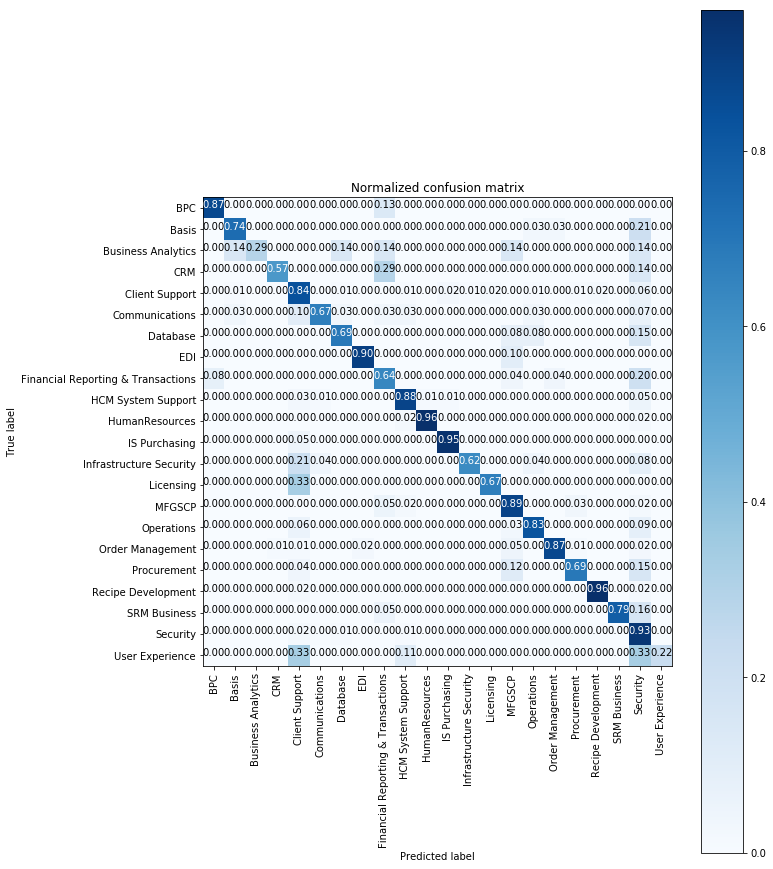

             precision    recall  f1-score   support

          0       0.87      0.87      0.87        15
          1       0.89      0.74      0.81        34
          2       1.00      0.29      0.44         7
          3       0.80      0.57      0.67         7
          4       0.79      0.84      0.82       129
          5       0.87      0.67      0.75        30
          6       0.64      0.69      0.67        13
          7       0.82      0.90      0.86        10
          8       0.62      0.64      0.63        25
          9       0.91      0.88      0.89        77
         10       0.98      0.96      0.97        47
         11       0.94      0.95      0.95        84
         12       0.94      0.62      0.75        24
         13       0.67      0.67      0.67         6
         14       0.82      0.89      0.85        61
         15       0.83      0.83      0.83        35
         16       0.96      0.87      0.91        85
         17       0.78      0.69      0.73   

In [4]:
#SECTION 4.4
##confusion matrix, P , R ,F1###################
cm = confusion_matrix(yt, predictedt)
class_names = pd.DataFrame(dict(c1=df['MA_Support_Group'].unique(),
                  c2=le.transform(df['MA_Support_Group'].unique())))
class_names = class_names.sort_values(['c2'])['c1'].tolist()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig = plt.gcf()
    fig.set_size_inches(10.5, 15.5, forward=True)

np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print(classification_report(yt, predictedt))
print('F1 weighted: ', f1_score(yt, predictedt, average='weighted'), 'F1 micro', f1_score(yt, predictedt, average='micro'), 'F1 macro',
      f1_score(yt, predictedt, average='macro'))

In [5]:
#SECTION 4.5
##--testing out the model casually#############
#Test Case #1 - Should return Licensing Team
str_new = 'I need a license for MS Project Pro'
docs_new = [lmtzr.lemmatize(word) for word in str_new.split()]
docs_new = [ps.stem(word) for word in docs_new]
docs_new = [' '.join(docs_new)]
vecDoc = vectorizer.transform(docs_new)
Yhat = clf.predict(vecDoc)
print (list(le.inverse_transform(Yhat)))

#Test Case #2 - Should return the IS Purchasing team
str_new = 'Hi , create a PO to purchase some power adapters and a new monitor'
docs_new = [lmtzr.lemmatize(word) for word in str_new.split()]
docs_new = [ps.stem(word) for word in docs_new]
docs_new = [' '.join(docs_new)]
vecDoc = vectorizer.transform(docs_new)
Yhat = clf.predict(vecDoc)
print (list(le.inverse_transform(Yhat)))

#Test Case #3 - Should return the Reciepe Development Team
str_new = 'Hi, there is an issue with our ECR workflow not going to the product development team'
docs_new = [lmtzr.lemmatize(word) for word in str_new.split()]
docs_new = [ps.stem(word) for word in docs_new]
docs_new = [' '.join(docs_new)]
vecDoc = vectorizer.transform(docs_new)
Yhat = clf.predict(vecDoc)
print (list(le.inverse_transform(Yhat)))

['Licensing']
['IS Purchasing']
['Recipe Development']


In [ ]:
#Section 5.1 and 5.2 do not need to be run by the user

#SECTION 5.1
##cross validation testing ##############################
cvX = vectorizer.transform(df['j_tokenized_text'].apply(str))
cvy = le.transform(df['MA_Support_Group'].tolist())
cvclf = svm.SVC(kernel='linear', C=3)
scores = cross_val_score(cvclf, cvX, cvy, cv=8)
scores.mean(), scores.std()

In [ ]:
#SECTION 5.2
##testing out grid search cross validation - C = 3 was the best #####
param_grid = [{'C': [4, 1, 2, 3], 'kernel': ['linear']}]
gsclf = GridSearchCV(svm.SVC(C=1), param_grid=param_grid, cv=7)
gsclf.fit(X,y)
gscvresults = pd.DataFrame(dict(gsclf.cv_results_))
predictedgs = gsclf.predict(Xt)

print(classification_report(yt, predictedgs))

In [ ]:
#SECTION 6.1
##testing out decision trees - Only 70% F1 ##############
clf_gini = DecisionTreeClassifier(criterion = "gini")
clf_gini.fit(X, y)
predicteddt = clf_gini.predict(Xt)
print(classification_report(yt, predicteddt))

##testing out NB - Only around 50% F1 ###################
mnnb = clf = MultinomialNB()
mnnb.fit(X, y)
predictednb = mnnb.predict(Xt)
print(classification_report(yt, predictednb))

In [6]:
#SECTION 6.2 - LDA AND NMF APPROACH
#combined the output of SVM model with the LDA/NMF features to form dense matrix and fed into a new SVM
#LDA showed no improvement. NMF showed a 1% improvement
#####NMF with ensemble SVM probability scores gave +1% greater than simple SVM so not worth ithe apped complexity.
tf_vectorizer = CountVectorizer()
Xlda = tf_vectorizer.fit_transform(X_train.apply(str))
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_topics=15, learning_method='online').fit(Xlda)

tfidf_feature_names = vectorizer.get_feature_names()
nmf = NMF(n_components=30, random_state=1, alpha=0, l1_ratio=.5, init='nndsvd',
          beta_loss=2).fit(X)



predictedprob = clf.predict_proba(X)
doc_topic_dist_unnormalized = pd.DataFrame(nmf.transform(X))
doc_topic_dist = doc_topic_dist_unnormalized.div(doc_topic_dist_unnormalized.sum(axis=1), axis=0)
doc_topic_svm = np.concatenate((doc_topic_dist.as_matrix(),predictedprob),axis=1)
doc_topic_svm = np.nan_to_num(doc_topic_svm)
doc_topic_dist = np.nan_to_num(doc_topic_dist)
clfems = svm.SVC(kernel='linear', C=3).fit(doc_topic_svm,y)
#clfems = svm.SVC(kernel='linear', C=3).fit(doc_topic_dist,y)


predictedprobtest = clf.predict_proba(Xt)
doc_topic_dist_unnormalizedt = pd.DataFrame(nmf.transform(Xt))
doc_topic_distt = doc_topic_dist_unnormalizedt.div(doc_topic_dist_unnormalizedt.sum(axis=1), axis=0)
doc_topic_svmt = np.concatenate((doc_topic_distt.as_matrix(),predictedprobtest),axis=1)
doc_topic_svmt = np.nan_to_num(doc_topic_svmt)
doc_topic_distt = np.nan_to_num(doc_topic_distt)
predictedems = clfems.predict(doc_topic_svmt)
#predictedems = clfems.predict(doc_topic_distt)


#confusion matrix, P , R ,F1
#cmems = confusion_matrix(yt, predictedems)
print(classification_report(yt, predictedems))

print(f1_score(yt, predictedems, average='weighted'), f1_score(yt, predictedems, average='micro'),
      f1_score(yt, predictedems, average='macro'))


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

display_topics(nmf, tfidf_feature_names, no_top_words)

             precision    recall  f1-score   support

          0       0.42      0.53      0.47        15
          1       0.62      0.59      0.61        34
          2       1.00      0.29      0.44         7
          3       0.38      0.43      0.40         7
          4       0.70      0.74      0.72       129
          5       0.64      0.53      0.58        30
          6       0.67      0.62      0.64        13
          7       0.73      0.80      0.76        10
          8       0.53      0.72      0.61        25
          9       0.86      0.73      0.79        77
         10       0.81      0.83      0.82        47
         11       0.88      0.83      0.85        84
         12       0.56      0.38      0.45        24
         13       0.00      0.00      0.00         6
         14       0.73      0.66      0.69        61
         15       0.72      0.74      0.73        35
         16       0.82      0.74      0.78        85
         17       0.55      0.62      0.58   

C:\Users\Splinta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#SECTION 6.3
#######testing out one hot of names##########################
#toverall train
enc = OneHotEncoder(sparse=False)
lep = preprocessing.LabelEncoder()
lep.fit(df['Team'].unique().tolist())
leptrans = lep.transform(df['Team'].unique().tolist())
leptrans = leptrans.reshape(-1, 1)
enc.fit(leptrans)

#train
leptrain = lep.transform(X_train['Team'].apply(str))
leptrain = leptrain.reshape(-1, 1)
ohetrain = enc.transform(leptrain)

#fitting ohe plus prob svm into new svm
predictedprob = clf.predict_proba(X)
combined_feat = np.concatenate((ohetrain,predictedprob),axis=1)
clfohe = svm.SVC(kernel='linear', C=1).fit(combined_feat,y)

#test
leptest = lep.transform(X_test['Team'].apply(str))
leptest = leptest.reshape(-1, 1)
ohetest = enc.transform(leptest)

#testing ohe plus prob svm into new svm
predictedprobtest = clf.predict_proba(Xt)
combined_feat_test = np.concatenate((ohetest,predictedprobtest),axis=1)
predictedohe = clfohe.predict(combined_feat_test)

print(classification_report(yt, predictedohe))
print(f1_score(yt, predictedohe, average='weighted'), f1_score(yt, predictedohe, average='micro'),
      f1_score(yt, predictedohe, average='macro'))
#### Below are mapping tables to view test, train and confusion matrix results easier